In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, md5, concat_ws
import matplotlib.pyplot as plt
import pandas as pd


In [21]:

spark = SparkSession.builder.appName("SmsEventos").getOrCreate()
eventos_df = spark.read.csv("eventos.csv.gz", header=True, inferSchema=True)
free_sms_df = spark.read.csv("free_sms_destinations.csv.gz", header=True, inferSchema=True)
eventos_df = eventos_df.dropna(subset=["id_source", "id_destination"])
eventos_df = eventos_df.withColumn(
    "sms_cost",
    when(col("id_destination").isin([row["id"] for row in free_sms_df.collect()]), 0.0)
    .when(col("region").between(1, 5), col("sms") * 1.5)
    .when(col("region").between(6, 9), col("sms") * 2.0)
    .otherwise(0.0)
)

In [22]:
total_facturacion = eventos_df.select(sum("sms_cost")).collect()[0][0]
print(f"Monto total facturado: ${total_facturacion:.2f}")
usuarios_facturacion = (
        eventos_df.groupBy("id_source")
        .agg(sum("sms_cost").alias("total_facturado"))
        .orderBy(col("total_facturado").desc())
        .limit(100)
    )


Monto total facturado: $4265.50


In [13]:
usuarios_facturacion = usuarios_facturacion.withColumn("id_hashed", md5(concat_ws("", col("id_source"))))
usuarios_facturacion.write.parquet("usuarios_top100.parquet", compression="gzip",mode='overwrite')
llamadas_por_hora = eventos_df.groupBy("hour").agg(sum("calls").alias("total_calls"))
llamadas_df = llamadas_por_hora.toPandas()


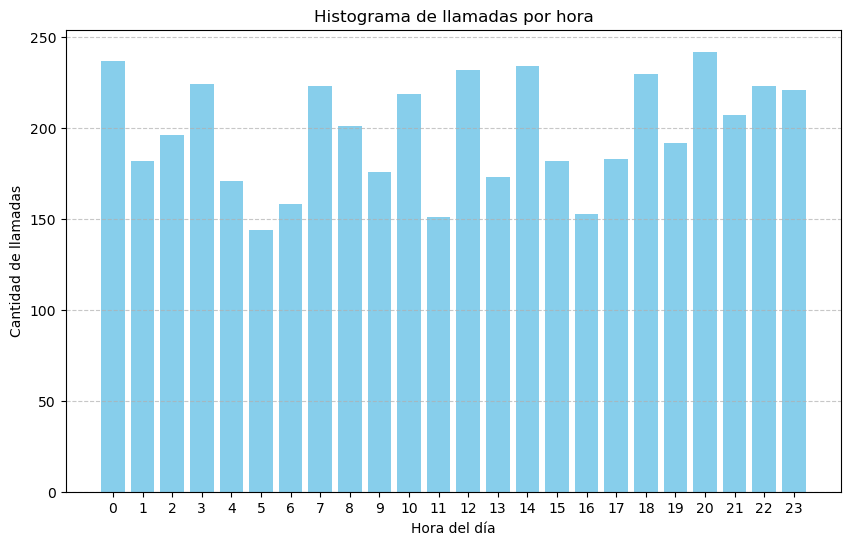

In [14]:
plt.figure(figsize=(10,6))
plt.bar(llamadas_df["hour"], llamadas_df["total_calls"], color='skyblue')
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de llamadas")
plt.title("Histograma de llamadas por hora")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("histograma_llamadas.png")
plt.show()